# Statistical Gridding of Data from The Ocean Data Platform

In this notebook we will download ocean temperature measurements from the seas around Scandinavia and create a map of the average summer ocean temperatures, at 10m depth, for the year 2018. This includes:
- Downloading data fron the Ocean Data Platform
- Interpolating each temperature profile to get the temperature at 10m depth
- Create a gridded map of the mean summer temperature using 2D and 3D interpolation techniques

In [1]:
from odp_sdk import ODPClient

from CastFunctions import * # Helper functions
import cmocean #Colormaps for oceanography

client = ODPClient(api_key='xxxxxxxxxxxxxxx')

import warnings
warnings.filterwarnings("ignore")

Connected


In [2]:
df=client.casts(longitude=[-25,35],
                latitude=[50,80],
                timespan=['2018-06-01','2018-08-31'],
                parameters=['date','lon','lat','z','Temperature'],
                include_flagged_data=False)

Locating available casts..
-> 9147 casts found
-> 1159275 data rows downloaded in 74.35s


In [3]:
df.head()

,externalId,datetime,date,lon,lat,z,Temperature
0,cast_wod_3_2018_28041_18846836,2018-07-13,20180713,-24.2021,50.2499,23.693201,14.106
1,cast_wod_3_2018_28041_18846836,2018-07-13,20180713,-24.2021,50.2499,29.739977,13.276
2,cast_wod_3_2018_28041_18846836,2018-07-13,20180713,-24.2021,50.2499,34.993591,13.042
3,cast_wod_3_2018_28041_18846836,2018-07-13,20180713,-24.2021,50.2499,39.553223,12.749
4,cast_wod_3_2018_28041_18846836,2018-07-13,20180713,-24.2021,50.2499,47.086300,12.627


In [4]:
df=df[df.z<50] #Only keep data shallower than 50m

## Interpolate casts to desired depths

In [5]:
df_int=interpolate_casts_to_z(df,'Temperature',[0,10,20]) # This one takes a long time

In [6]:
df_int.dropna(inplace=True)
df_int=df_int[df_int.Temperature>-2]
df_int.describe()

,lon,lat,z,Temperature
count,21078.000000,21078.000000,21078.000000,21078.000000
mean,2.025875,59.655496,10.241010,12.932029
std,9.650279,7.309965,7.985301,4.549271
min,-24.936000,50.038000,0.000000,-1.480000
25%,-4.660000,54.922500,0.000000,10.122165
50%,1.017000,57.484000,10.000000,13.740000
75%,9.479000,61.563750,20.000000,16.223526
max,34.002500,79.999664,20.000000,25.802584


# Ocean temperature measurements

In [7]:
df_int=df_int[(df_int.datetime>'2018-06-01')& (df_int.datetime<'2018-08-31') &(df_int.z==10)]

Text(0.5, 1.0, 'Ocean Temperatures at 10m Depth')

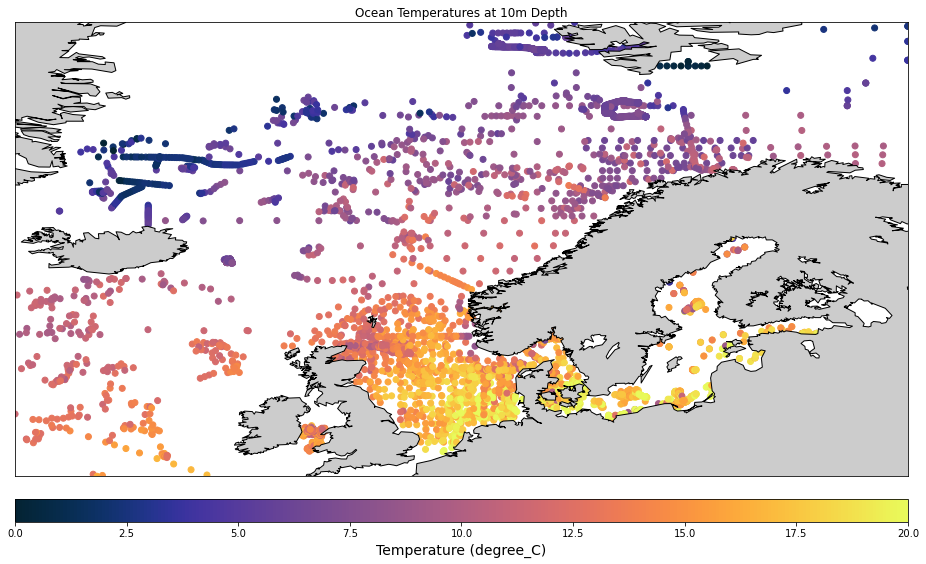

In [8]:
plot_casts('Temperature',df_int,cmap=cmocean.cm.thermal,vrange=[0,20]);plt.title('Ocean Temperatures at 10m Depth')

# Ocean summer temperature gridding 2D (longitude,latitude)

In [9]:

points=df_int[['lon','lat']].values.astype('float')
values=df_int['Temperature'].values.astype('float')


int_points=[np.linspace(-25,35,60*10+1),np.linspace(50,80,30*10+1)]


### Mean Summer Temperature - Radial Basis Function (RBF)

In [10]:
kind='rbf'
grid,g=interpolate_to_grid(points.copy(),values.copy(),int_points.copy(), interp_type=kind,
                               rbf_func='linear',rbf_smooth=0.1,rescale=True)


Text(0.5, 1.0, 'rbf')

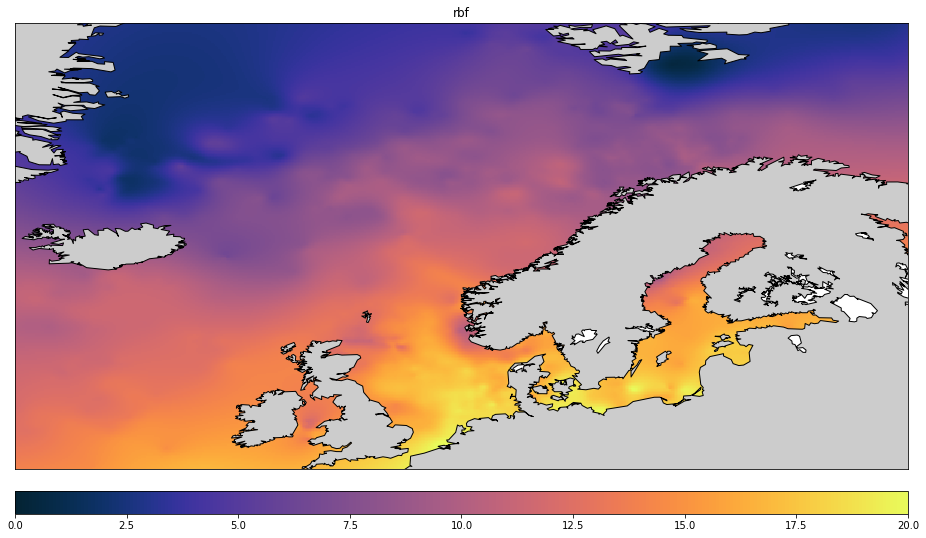

In [11]:
plot_grid(grid[0],grid[1],g,cmap=cmocean.cm.thermal,vrange=[0,20])
plt.title(kind)

### Mean Summer Temperature - Linear + Nearest

In [12]:
kind='rbf'
grid,g0=interpolate_to_grid(points.copy(),values.copy(),int_points.copy(), interp_type='nearest',rescale=True)
grid,g1=interpolate_to_grid(points.copy(),values.copy(),int_points.copy(), interp_type='linear',rescale=True)

g=g1.copy()
g[np.isnan(g)]=g0[np.isnan(g)] # Filling the empty boundary values in linear interpolation with nearest

Text(0.5, 1.0, 'Linear + Nearest')

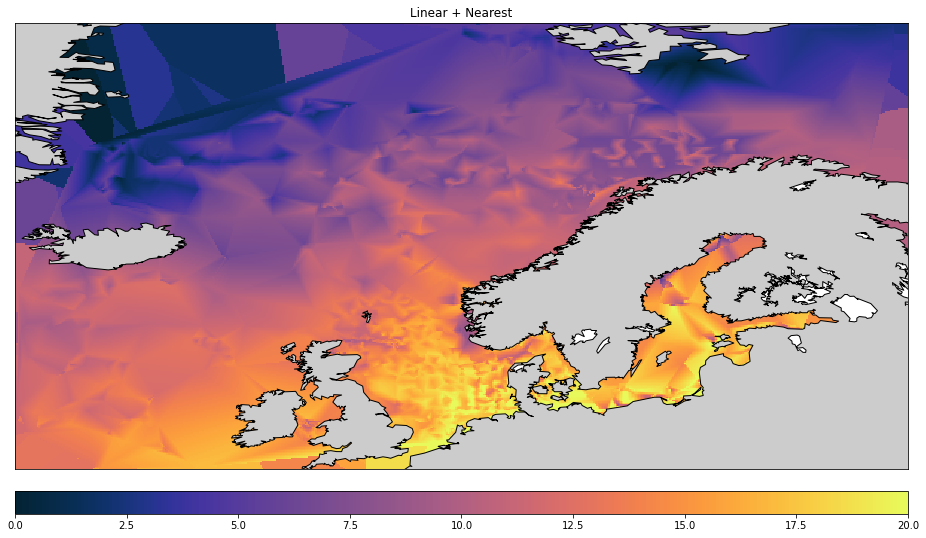

In [13]:
plot_grid(grid[0],grid[1],g,cmap=cmocean.cm.thermal,vrange=[0,20])
plt.title('Linear + Nearest')

# Ocean temperature gridding 3D (longitude,latitude and time)

In [14]:
    
df_int['unixtime']=df_int['datetime'].apply(lambda x : x.value) 
df_int.dropna(inplace=True)
points=df_int[['lon','lat','unixtime']].values.astype('float')
values=df_int['Temperature'].values .astype('float')

int_points=[np.linspace(-25,35,60*4+1),
            np.linspace(50,80,30*4+1),
            np.linspace(pd.Timestamp('2018-06-01').value,pd.Timestamp('2018-08-31').value,8)]
    
    

### Mean Summer Temperature - Linear Interpolation 

In [15]:
grid,g0=interpolate_to_grid(points.copy(),values.copy(),int_points.copy(), interp_type='nearest',rescale=True)
grid,g1=interpolate_to_grid(points.copy(),values.copy(),int_points.copy(), interp_type='linear',rescale=True)
g=g1.copy()
g[np.isnan(g)]=g0[np.isnan(g)] # Filling the empty boundary values in linear interpolation with nearest

Text(0.5, 1.0, 'Linear + nearest')

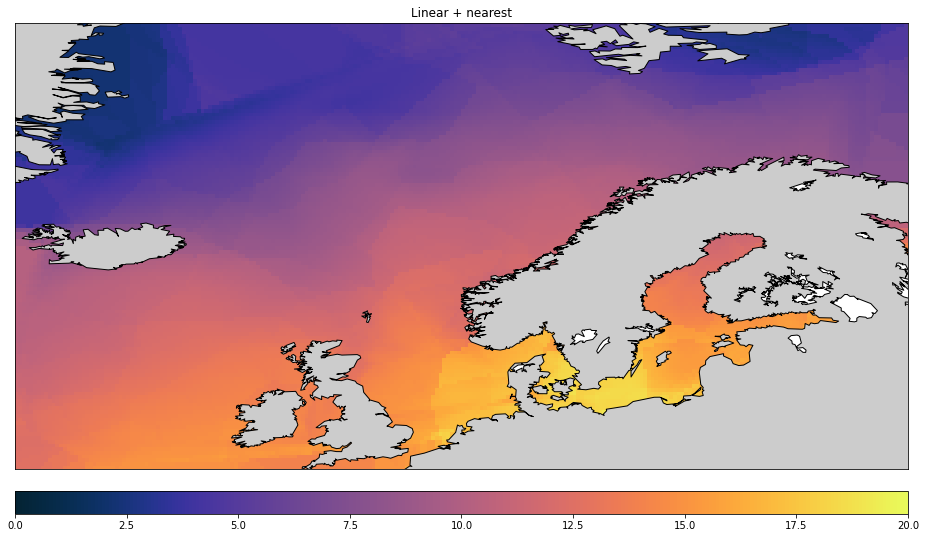

In [16]:
t_mean=np.nanmean(g,axis=2)
plot_grid(grid[0][:,:,0],grid[1][:,:,0],t_mean,cmap=cmocean.cm.thermal,vrange=[0,20])
plt.title('Linear + nearest')

### Mean Summer Temperature - Radial Basis Function (RBF) 

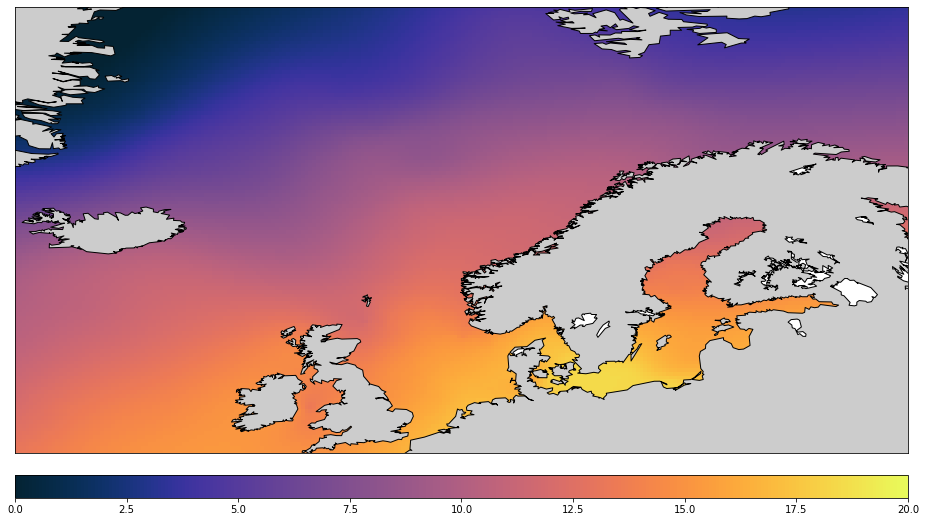

In [17]:
grid,g=interpolate_to_grid(points.copy(),values.copy(),int_points.copy(), interp_type='rbf',rbf_smooth=1e-9,rescale=True)

t_mean=np.nanmean(g[:,:],axis=2)
plot_grid(grid[0][:,:,0],grid[1][:,:,0],t_mean,cmap=cmocean.cm.thermal,vrange=[0,20])#;plt.title(interp_type)


### Standard Deviation Summer Temperature - Radial Basis Function (RBF) 

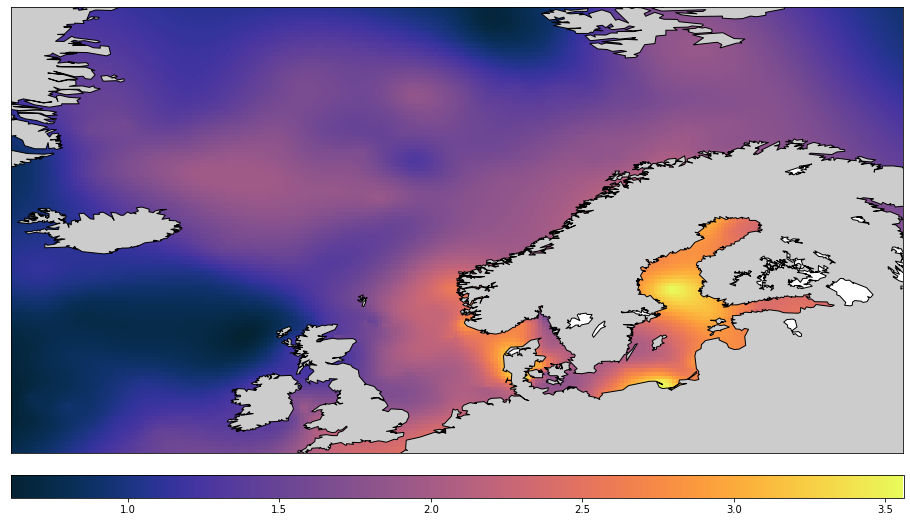

In [19]:
t_std=np.nanstd(g[:,:],axis=2)
plot_grid(grid[0][:,:,0],grid[1][:,:,0],t_std,cmap=cmocean.cm.thermal,vrange=[t_std.min(),t_std.max()])#;plt.title(interp_type)
